<center><img src="https://i.postimg.cc/T2FfYwNJ/330px-Bolt-logo.png" /></center>
<marquee style="width:94%;color: black;font-size : 28px">

<b>Task 1 - Bolt Homework - Identifying Patterns on Supply-Demand Data Sample</b></marquee>

[Link](https://docs.google.com/document/d/1arKExVIq000xrX-yIhi1C1HyD3Cejx3R9zqe7yB2_XU/edit#)

# **&#10096; Context &#10097;**
---


Bolt is a ride hailing platform that connects riders (demand) with drivers (supply). At times, our service quality and hence rider experience depend on the supply that we have. We might not have sufficient supply to service the demand volume that we have during some peak hours, and therefore we might need to offer extra incentives in order to attract more supply.
In this task (at the end of this document), you are given 2 sample datasets that contain aggregated activities of riders and drivers over a few weeks in a city where Bolt operates. Using these data, we expect you to build a good understanding around the state of demand and supply in the given city. Most importantly, we need to understand if our supply volume matches the demand that we have. If it does not, we need to pinpoint the peak hours and come up with recommended actions.

**Question**

1. Please **identify the time periods that are critical to us, i.e. when we are undersupplied**, and explain your reasonings. The following visualizations might be important to give us a better illustration of the demand-supply state:

  `a.` **24-hour curve of average demand and supply volume** (to illustrate if there is any match/mismatch)

  `b.` Undersupplied hours during a weekly period (Monday to Sunday) so that we can send to drivers and inform them when to be online for extra hours

2. Please calculate the **number of online hours required to ensure that we have a good Coverage Ratio during the peak hours** you identified above.

3. During peak hours, we can guarantee the drivers a certain amount of income. If the drivers make less than the guaranteed amount, we will pay them the difference. Please calculate how much earning we can guarantee so that we can attract more supply. Please explain your reasonings and you can assume the following:

  `>.` Finished Rides have an average value of €10 (80% goes to drivers, 20% is our revenue)

  `>.` With extra online hours available we will be able to capture the "missed coverage", i.e. "People saw 0 cars" in the demand sample data


In [ ]:
!pip install unidecode
!pip install re

     |████████████████████████████████| 235 kB 5.3 MB/s 
ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re


In [ ]:
#Main libs
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

#Columns treatment
import unidecode 
import re 

# **&#10096; Importing &#10097;**
---


In [152]:
#Stablishing connection and importing drive libs to import our data
from google.colab import auth
from oauth2client.client import GoogleCredentials
import gspread
from google.auth import default
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

creds, _ = default()
gc = gspread.authorize(creds)

In [153]:
#Supply Data
gsheets = gc.open_by_url('https://docs.google.com/spreadsheets/d/19rPIk4WMi-2CQNUUjleeIrSSxSZ_hQY8eoXfVksfCvM/')
sheets = gsheets.worksheet('Hourly_DriverActivity_1.csv').get_all_values()

sp = pd.DataFrame(sheets[1:],columns=sheets[0])

#Demand Data
gsheets = gc.open_by_url('https://docs.google.com/spreadsheets/d/1rprkB_RfGHqh0hjL-hQN80djIxog9kAX_gg1lqKzuuM/')
sheets = gsheets.worksheet('Hourly_OverviewSearch_1.csv').get_all_values()

dm = pd.DataFrame(sheets[1:],columns=sheets[0])

In [154]:
sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Date                     840 non-null    object
 1   Active drivers           840 non-null    object
 2   Online (h)               840 non-null    object
 3   Has booking (h)          840 non-null    object
 4   Waiting for booking (h)  840 non-null    object
 5   Hours per active driver  840 non-null    object
 6   Rides per online hour    840 non-null    object
 7   Finished Rides           840 non-null    object
dtypes: object(8)
memory usage: 52.6+ KB


In [155]:
dm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839 entries, 0 to 838
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Date                         839 non-null    object
 1   People saw 0 cars (unique)   839 non-null    object
 2   People saw +1 cars (unique)  839 non-null    object
 3   Coverage Ratio (%)           839 non-null    object
dtypes: object(4)
memory usage: 26.3+ KB


# **&#10096; Data Wrangling &#10097;**
---


##Columns Formatting

In [156]:
#Column formatting

treat = sp.copy()
treat.drop(columns=treat.iloc[:,34:], inplace=True, axis=1)
treat.rename(columns =lambda x: x.strip().lower().replace(' p/',''), inplace=True)
treat.rename(columns =lambda x: x.strip().lower().replace('\n',''), inplace=True)
treat.rename(columns =lambda x: x.strip().lower().replace(' ','_'), inplace=True)

colunas = pd.Series(treat.columns)

for x in range(0,colunas.size):
  colunas[x] = unidecode.unidecode(colunas[x])
  colunas[x] = re.sub(r'\W+', '', colunas[x])

for x in range(0,colunas.size):
  treat.rename(columns={treat.columns[x]:colunas[x]},inplace=True)

sp = treat

#Splitting Date into date and date hour columns

sp.rename(columns={'date':'original_date'}, inplace=True)

sp['date_hour'] = list(map(lambda i:i[-2:],sp['original_date'].values))
sp['date'] = pd.to_datetime(list(map(lambda i:i[:-3],sp['original_date'].values)))

#Formatting column type
#sp[['active_drivers', 'online_h','has_booking_h','waiting_for_booking_h','finished_rides','hours_per_active_driver','rides_per_online_hour']] = sp[['active_drivers', 'online_h','has_booking_h','waiting_for_booking_h','finished_rides','hours_per_active_driver','rides_per_online_hour']].apply(pd.to_numeric)
sp.iloc[:,1:8] = sp.iloc[:,1:8].apply(pd.to_numeric)
sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   original_date            840 non-null    object        
 1   active_drivers           840 non-null    int64         
 2   online_h                 840 non-null    int64         
 3   has_booking_h            840 non-null    int64         
 4   waiting_for_booking_h    840 non-null    int64         
 5   hours_per_active_driver  840 non-null    float64       
 6   rides_per_online_hour    840 non-null    float64       
 7   finished_rides           795 non-null    float64       
 8   date_hour                840 non-null    object        
 9   date                     840 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(4), object(2)
memory usage: 65.8+ KB


Repeating the same procedure for the demand dataframe

In [157]:
#Column formatting

treat = dm.copy()
treat.drop(columns=treat.iloc[:,34:], inplace=True, axis=1)
treat.rename(columns =lambda x: x.strip().lower().replace(' p/',''), inplace=True)
treat.rename(columns =lambda x: x.strip().lower().replace('\n',''), inplace=True)
treat.rename(columns =lambda x: x.strip().lower().replace(' ','_'), inplace=True)

colunas = pd.Series(treat.columns)

for x in range(0,colunas.size):
  colunas[x] = unidecode.unidecode(colunas[x])
  colunas[x] = re.sub(r'\W+', '', colunas[x])

for x in range(0,colunas.size):
  treat.rename(columns={treat.columns[x]:colunas[x]},inplace=True)

dm = treat

#Splitting Date into date and date hour columns

dm.rename(columns={'date':'original_date'}, inplace=True)

dm['date_hour'] = list(map(lambda i:i[-2:],dm['original_date'].values))
dm['date'] = pd.to_datetime(list(map(lambda i:i[:-3],dm['original_date'].values)))

#Formatting column type
##dm.iloc[:,1:] = dm.iloc[:,1:4].apply(pd.to_numeric) for some reason it's not working
columns = dm.iloc[:,1:].columns.values

for x in columns:
  dm.iloc[:,1:4] = dm.iloc[:,1:4].apply(pd.to_numeric)
dm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839 entries, 0 to 838
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   original_date             839 non-null    object        
 1   people_saw_0_cars_unique  839 non-null    int64         
 2   people_saw_1_cars_unique  839 non-null    int64         
 3   coverage_ratio_           839 non-null    int64         
 4   date_hour                 839 non-null    object        
 5   date                      839 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 39.5+ KB


##Date Formatting

In order to better interact with our data, I'll be creating new columns: `day_name`, `day_number`, and `month`

In [122]:
#Creating date columns for supply dataframe
sp['day_name'] = sp.date.dt.day_name()
sp['day_number'] = sp.date.dt.day_of_week #The week starts on monday therefore monday=0
sp['month'] = sp.date.dt.month

##Missing Values

In [ ]:
sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   original_date            840 non-null    object        
 1   active_drivers           840 non-null    int64         
 2   online_h                 840 non-null    int64         
 3   has_booking_h            840 non-null    int64         
 4   waiting_for_booking_h    840 non-null    int64         
 5   hours_per_active_driver  840 non-null    float64       
 6   rides_per_online_hour    840 non-null    float64       
 7   finished_rides           795 non-null    float64       
 8   date_hour                840 non-null    object        
 9   date                     840 non-null    datetime64[ns]
 10  day_name                 840 non-null    object        
 11  day_number               840 non-null    int64         
 12  month                    840 non-nul

It seems that we have a problem with our `finished_rides` column. There's 45 values missing, it represents 5.35% of our entire dataset.

In [ ]:
sp[sp.isna().any(axis=1)].describe()

,active_drivers,online_h,has_booking_h,waiting_for_booking_h,hours_per_active_driver,rides_per_online_hour,finished_rides,day_number,month
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.0,0.0,45.000000,45.000000
mean,22.222222,8.466667,0.155556,8.266667,0.371111,0.0,NaN,1.800000,11.555556
std,10.689606,5.079370,0.366529,5.019960,0.096818,0.0,NaN,1.713582,0.502519
min,9.000000,2.000000,0.000000,2.000000,0.100000,0.0,NaN,0.000000,11.000000
25%,16.000000,5.000000,0.000000,5.000000,0.300000,0.0,NaN,1.000000,11.000000
50%,20.000000,8.000000,0.000000,8.000000,0.400000,0.0,NaN,1.000000,12.000000
75%,25.000000,10.000000,0.000000,10.000000,0.400000,0.0,NaN,3.000000,12.000000
max,73.000000,31.000000,1.000000,30.000000,0.600000,0.0,NaN,6.000000,12.000000


The descriptive statistics above show us that there is something weird happening in our `has_booking_h`. We do have active drivers at these dateframe and also people waiting for booking but we have almost no record on that column. Let's investigate to check if that's a normal behavior or not.

In [ ]:
print('Data with Missing values')
print(sp[sp.isna().any(axis=1)][['date_hour','has_booking_h']].groupby('date_hour').mean())
print('--- \n')
print('Data with NO Missing values')
print(sp[sp['date_hour'].isin(sp[sp.isna().any(axis=1)]['date_hour'])][['date_hour','has_booking_h']].groupby('date_hour').mean())

Data with Missing values
           has_booking_h
date_hour               
01              1.000000
02              0.000000
03              0.000000
04              0.153846
05              0.083333
06              0.000000
07              1.000000
09              0.000000
13              1.000000
--- 

Data with NO Missing values
           has_booking_h
date_hour               
01              5.200000
02              3.685714
03              3.114286
04              2.657143
05              1.314286
06              0.771429
07              2.628571
09             10.314286
13              4.000000


It looks like we clearly have a difference between the `has_booking_h` of most of our data and the data where we have missing values on the column `finished_rides`

In [ ]:
sp[sp.isna().any(axis=1)][['day_name','day_number','date']].drop_duplicates().groupby('day_name').count()

,day_number,date
day_name,,
Friday,1,1
Monday,4,4
Saturday,1,1
Sunday,3,3
Thursday,5,5
Tuesday,5,5
Wednesday,4,4


In [ ]:
sp[['day_name','day_number','date']].drop_duplicates().groupby('day_name').count()

,day_number,date
day_name,,
Friday,5,5
Monday,5,5
Saturday,5,5
Sunday,5,5
Thursday,5,5
Tuesday,5,5
Wednesday,5,5


Investigating the days in which we have null rows, it looks like we have quite a significant number of days in which consists our dataset that has a null row. 

In [ ]:
print(sp[sp.isna().any(axis=1)][['original_date','day_name','day_number']].groupby('day_name').count())
print(sp[sp.isna().any(axis=1)][['original_date','day_name','day_number','date_hour']].groupby('date_hour').count())
print('\n ---- \n')
print('Months in the dataset are {}'.format(sp['month'].unique())) 
print('Years in the dataset are {}'.format(sp.date.dt.year.unique()))

           original_date  day_number
day_name                            
Friday                 1           1
Monday                10          10
Saturday               2           2
Sunday                 3           3
Thursday               6           6
Tuesday               15          15
Wednesday              8           8
           original_date  day_name  day_number
date_hour                                     
01                     1         1           1
02                     3         3           3
03                     7         7           7
04                    13        13          13
05                    12        12          12
06                     4         4           4
07                     2         2           2
09                     2         2           2
13                     1         1           1

 ---- 

Months in the dataset are [11 12]
Years in the dataset are [2016]


Unfortunatelly it seems that we have a major problem here. We have only a month worth of running days in our dataset and from the same year. It seems we wouldnt be able to use the mean of those days to replace the null values since we don't have much data in common with the missing values.

We also can't remove the missing values because we have so few data.

Since the variable itself is `finished_rides` there's a tricky problem here. It looks like the same rows where we have `finished_rides` equal to null, our column `has_booking_h` has a value range from 0 to 1 which is an outlier value when compared to the mean in the same hours. At the same hours we can check that there was free drivers waiting for a booking and there was people looking for riders on the Demand Data, it just so happens that the bookings didn't happen.

It could be: 

> our database had a communication problem with our app and it failed at capturing the data from those hours

> the app had a problem and users couldn't book a ride

> we lost data for some reason when extracting this sample from the database

Since I don't know how what is the actual problem of that happened at those days at given hour, I'll list down some possible approaches regarding how to deal with this data.

> since this problem already happened and IF we REALLY need the data from that time period for our analysis instead of just checking it with the Data Engineering team and asking for a recovery, I recommend we use a Time Series approach in order to estimate the correct values of `has_booking_h` for that time period and then calculate an estimative of `finished_rides`. We must take into consideration model validation metrics such as accuracy, standard deviation and mean error.

> proceed with our analysis and simply go for 2 parallel analysis. One in which we will take into consideration a dataframe without the rows where `finished_rides` is null and another where we will take them into consideration.

> replace the values of `has_booking_h` with mean or median of the variable at given day and hour.

Following the objective given in the Document for this challenge, I will be specific and follow the second approach that I've recommended above. Althought if I had more time, more data and the possibility of getting to know what happened I would probabily opt for the first recommendation.

##Unifying


Creating our merged dataframe

In [ ]:
df = sp.merge(dm, how='left', on='original_date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 840 entries, 0 to 839
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   original_date             840 non-null    object        
 1   active_drivers            840 non-null    int64         
 2   online_h                  840 non-null    int64         
 3   has_booking_h             840 non-null    int64         
 4   waiting_for_booking_h     840 non-null    int64         
 5   hours_per_active_driver   840 non-null    float64       
 6   rides_per_online_hour     840 non-null    float64       
 7   finished_rides            795 non-null    float64       
 8   date_hour                 840 non-null    object        
 9   date                      840 non-null    datetime64[ns]
 10  day_name                  840 non-null    object        
 11  day_number                840 non-null    int64         
 12  month                 

# **&#10096; Exploratory Data Analysis &#10097;**

---


##Drivers (Supply) Info

For the supply data we have the following information:

*    **Date** – date and hour
*    **Active drivers** – number of active drivers (any level of activity) available
*    **Online (h)** – total supply hours available
*    **Has booking (h)** – total hours when drivers had a client booking (any state)
*    **Waiting for booking (h)** – total hours which drivers spent waiting for booking
*    **Hours per active driver** – average number of hours each driver was online
*    **Rides per online hour (RPH)** – average finished trips per online hour
*    **Finished Rides** – number of finished trips

Some of the columns in this dataset is actually the product of other two columns.

`Waiting for booking (h) = Online (h) -  Has booking (h)`

`Hours per active driver = Online (h) / Active drivers`

`Rides per online hour (RPH) = Finished Rides / Online (h)`

Therefore the only columns that are not a resulting product is `Date, Active drivers, Online (h), Has booking (h), Finished Rides`

### Distribution

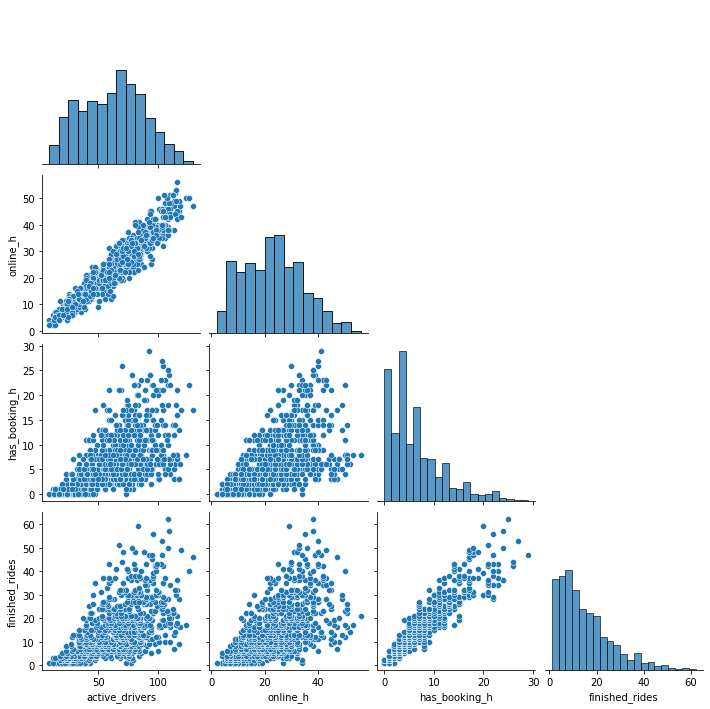

In [ ]:
vars1 = ['active_drivers','online_h','has_booking_h','finished_rides']
vars2 = ['waiting_for_booking_h','hours_per_active_driver','rides_per_online_hour']

sn.pairplot(sp, vars=vars1, corner=True)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 1.0, 'Boxplot of Vars 1 ')

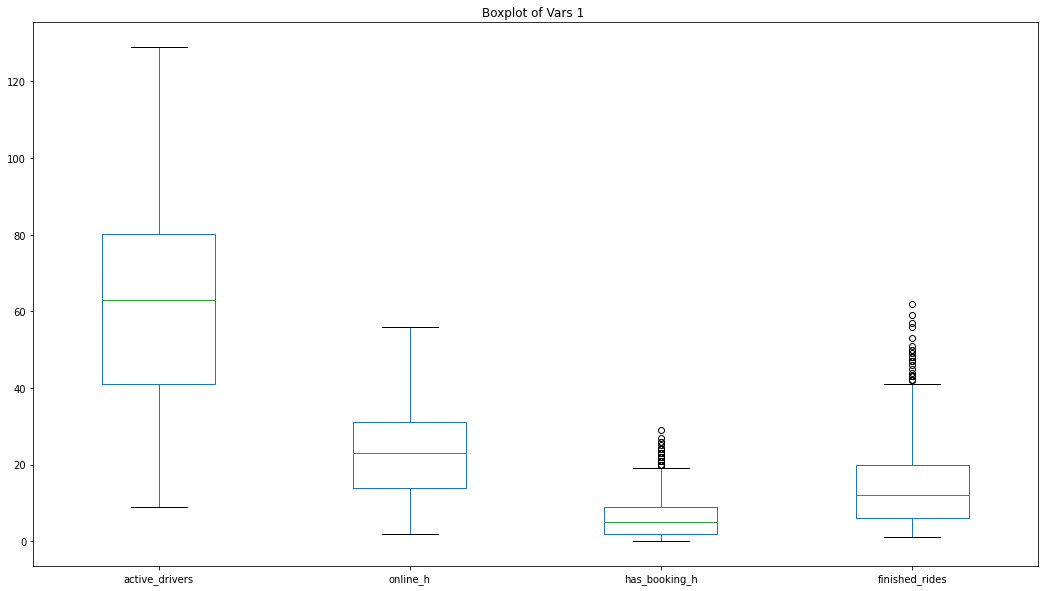

In [ ]:
boxplot = sp[vars1].boxplot(figsize=(18,10), grid=False)
plt.title('Boxplot of Vars 1 ')

In [ ]:
teste.active_drivers.skew()

0.029732918616767173

**Checking Normality** 

Although looking at the graph it looks like our data is slitly skewed to the left and also that by business understanding it would make more sense if our data follows a Poisson distribution rather than a normal distribution because i.e.: number of active drivers will very throught time, and time being the  I will indeed check their pvalues on Shapiro Wilk test just for the sake of it.

> **Shapiro Wilk**

The Shapiro Wilk has been developed specifically for the normal distribution, and it returns for us the W statistics and the P-value, although in samples where N > 5000 the W statistics will be accurate but the p-value may not be.

> **Ho (null hypothesis)** = The sample is normally distributed

> **H1 (alternative hypothesis** = The sample is not normally distributed

> **alpha** = 0.05

Therefore if the p-value < alpha the null hypothesis is rejected and it indicates that the data may not be normally distributed.

> **Disclaimer** p-value is the probability of obtaining results at least as extreme as the observed results of a statistical hypothesis test. The smaller the p-value means that there is stronger evidence in favor of the alternative hypothesis. The pvalue ranges from 0 to 1. On Shapiro Wilk the pvalue is used to determine wether we will reject the null hypothesis or not, based on if the pvalue < alpha or not. The alpha value is the confidence interval of our distribution.


(0.9992886781692505, 3.126801445273936e-18)
The null hypothesis may be rejected. Therefore it doesnt follow a normal distribution 



/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


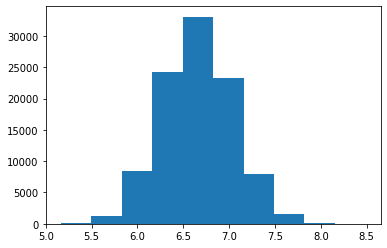

In [ ]:
means_size_100 = []

for x in range(int(1e5)):
    sample = np.random.choice(teste['has_booking_h'],200)
    means_size_100.append(sample.mean())

plt.hist(means_size_100)

a,b = stats.shapiro(means_size_100)
print(stats.shapiro(means_size_100))
if b < alpha:
   print('The null hypothesis may be rejected. Therefore it doesnt follow a normal distribution \n')
else:
   print('The null hypothesis may not be rejected. Therefore it follows a normal distribution \n')

In [ ]:
from scipy import stats
alpha = 0.05

teste = sp[sp['finished_rides'] >= 0].copy()

print('Validation of the first set of variables \n ')

for x in vars1:
  a,b = stats.shapiro(teste[x])
  print('The value of the statistics W and p-value for variable {}'.format(x) + ' is {}'.format(stats.shapiro(teste[x])))
  if b < alpha:
    print('The null hypothesis may be rejected. Therefore it doesnt follow a normal distribution \n')
  else:
    print('The null hypothesis may not be rejected. Therefore it follows a normal distribution \n')

print('------------ \n')
print('Validation of the second set of variables \n ')

for x in vars2:
  a,b = stats.shapiro(teste[x])
  print('The value of the statistics W and p-value for variable {}'.format(x) + ' is {}'.format(stats.shapiro(teste[x])))
  if b < alpha:
    print('The null hypothesis may be rejected. Therefore it doesnt follow a normal distribution \n')
  else:
    print('The null hypothesis may not be rejected. Therefore it follows a normal distribution \n')

Validation of the first set of variables 
 
The value of the statistics W and p-value for variable active_drivers is (0.9870576858520508, 1.758273924679088e-06)
The null hypothesis may be rejected. Therefore it doesnt follow a normal distribution 

The value of the statistics W and p-value for variable online_h is (0.9852145314216614, 3.440786144892627e-07)
The null hypothesis may be rejected. Therefore it doesnt follow a normal distribution 

The value of the statistics W and p-value for variable has_booking_h is (0.8829269409179688, 5.07320274123023e-24)
The null hypothesis may be rejected. Therefore it doesnt follow a normal distribution 

The value of the statistics W and p-value for variable finished_rides is (0.9057359099388123, 9.657213492263515e-22)
The null hypothesis may be rejected. Therefore it doesnt follow a normal distribution 

------------ 

Validation of the second set of variables 
 
The value of the statistics W and p-value for variable waiting_for_booking_h is (0.9

### Behavior

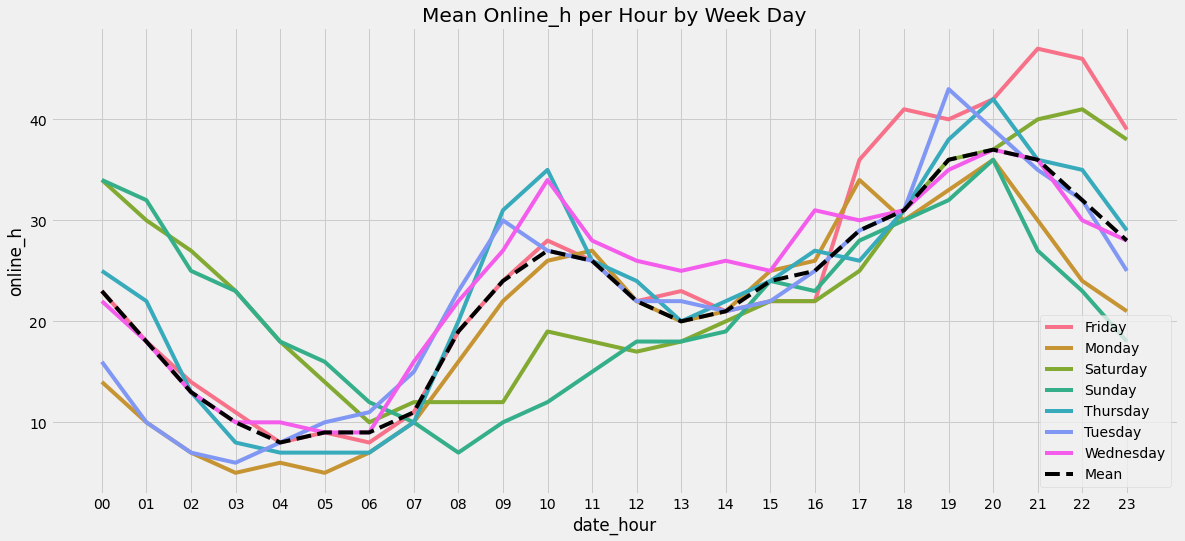

In [ ]:
hours = sp[['online_h','has_booking_h','waiting_for_booking_h','day_name','date_hour']]
hours = hours.groupby(['day_name','date_hour']).median()
hours_mean = hours.groupby(['date_hour']).median()

plt.figure(figsize = (18,8))
sn.lineplot(y='online_h', x='date_hour', hue='day_name', data=hours)
sn.lineplot(y='online_h', x='date_hour', data=hours_mean, color='black', linestyle='--', label='Mean')
plt.title('Mean Online_h per Hour by Week Day')
plt.show()

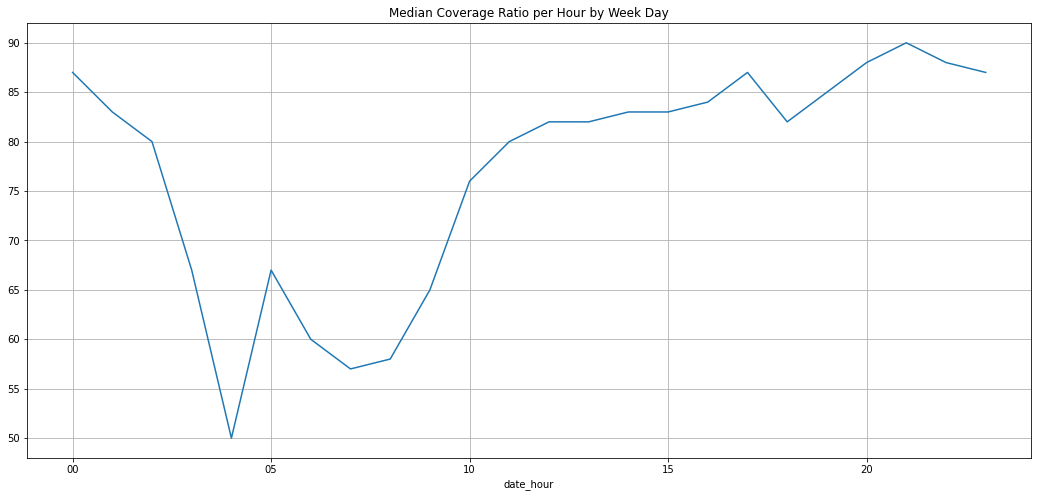

In [158]:
graf = dm.groupby('date_hour').median()

plt.figure(figsize = (18,8))
graf.coverage_ratio_.plot()
plt.title('Median Coverage Ratio per Hour by Week Day')
plt.grid()
plt.show()

In [150]:
#We wont need the columns on dm anymore
dm.drop(columns={'date','date_hour'}, inplace=True)

# **&#10096; Questions &#10097;**

---


## Question 1

`1.` Please identify the time periods that are critical to us, i.e. when we are undersupplied, and explain your reasonings. The following visualizations might be important to give us a better illustration of the demand-supply state:

> `a.` 24-hour curve of average demand and supply volume (to illustrate if there is any match/mismatch)


**Disclaimer**

> Since our data doesn't behave like a gaussion distribution as shown above in our EDA phase, I will be using the median for our calculations instead of the mean. It will allow us to make safer conclusions about our data.

In [160]:
#Calculating values for dataset without null values
df_n = df[df.finished_rides >=0].copy()

hourn = df_n.iloc[:,1:]

dxs = hourn[['day_name','day_number','date_hour','people_saw_0_cars_unique','people_saw_1_cars_unique','active_drivers']].copy()
dxs['demand'] = dxs['people_saw_0_cars_unique'] + dxs['people_saw_1_cars_unique']
#dxs.drop(columns={'people_saw_0_cars_unique','people_saw_1_cars_unique'}, inplace=True)
dxs.rename(columns={'active_drivers':'supply'},inplace=True)

#Calculating values for dataset with null values
df_n = df.copy()
hourn2 = df_n.iloc[:,1:]

dxs2 = hourn2[['day_name','day_number','date_hour','people_saw_0_cars_unique','people_saw_1_cars_unique','active_drivers']].copy()
dxs2['demand'] = dxs2['people_saw_0_cars_unique'] + dxs2['people_saw_1_cars_unique']
#dxs2.drop(columns={'people_saw_0_cars_unique','people_saw_1_cars_unique'}, inplace=True)
dxs2.rename(columns={'active_drivers':'supply'},inplace=True)

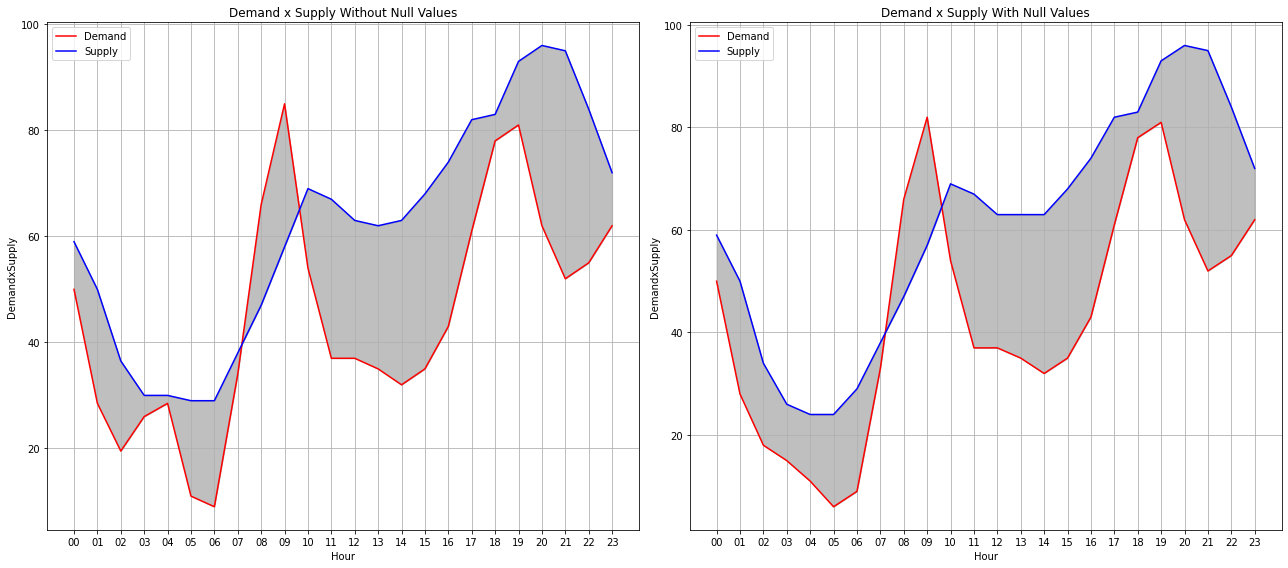

In [161]:
import matplotlib.style as style

fig = plt.figure(figsize = (18,8))

#Plot without null values
plt.subplot(1,2,1)
#style.use('fivethirtyeight')
plt.plot(dxs.groupby('date_hour').median()['demand'], color='red', label='Demand')
plt.plot(dxs.groupby('date_hour').median()['supply'], color='blue', label='Supply')
plt.fill_between(dxs.groupby('date_hour').median().index, dxs.groupby('date_hour').median()['supply'], dxs.groupby('date_hour').median()['demand'], color='grey', alpha=0.5)
plt.xlabel('Hour')
plt.ylabel('DemandxSupply')
plt.title('Demand x Supply Without Null Values')
plt.legend(loc='best')
plt.grid()

#Plot with null values
plt.subplot(1,2,2)
#style.use('fivethirtyeight')
plt.plot(dxs2.groupby('date_hour').median()['demand'], color='red', label='Demand')
plt.plot(dxs2.groupby('date_hour').median()['supply'], color='blue', label='Supply')
plt.fill_between(dxs2.groupby('date_hour').median().index, dxs2.groupby('date_hour').median()['supply'], dxs2.groupby('date_hour').median()['demand'], color='grey', alpha=0.5)
plt.xlabel('Hour')
plt.ylabel('DemandxSupply')
plt.title('Demand x Supply With Null Values')
plt.legend(loc='best')
plt.grid()

plt.tight_layout()
plt.show()

Considering the volume above it looks like most of our working hours along the week has an undersupply problem. Although at some time periods there is a bigger difference betwen the Demand and Supply. In order to be more assertive and and avoid problems I'll be calculating the Standard Deviation between both Supply and Demand, and I'll consider the undersupplied hours when our difference between supply and demand goes below the deviation.

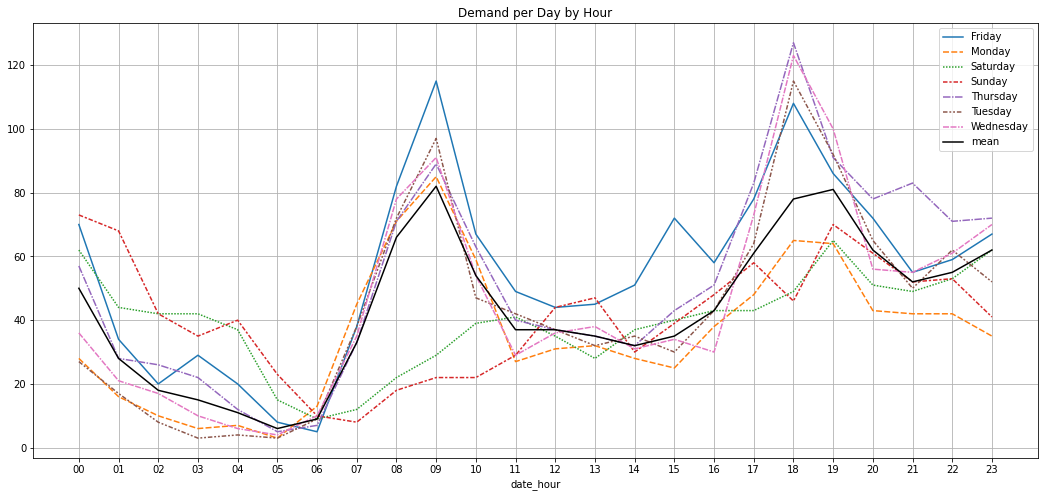

In [162]:
#Transposing data
trans = dxs2.groupby(['date_hour','day_name']).median().reset_index()
trans = trans.pivot(values='demand', index='date_hour', columns='day_name')
trans['mean'] = dxs2.groupby(['date_hour']).median()['demand']

#Ploting graphs
fig = plt.figure(figsize = (18,8))
sn.lineplot(data=trans.iloc[:,:7])
trans['mean'].plot(color='black', label='mean')
plt.title('Demand per Day by Hour')
plt.grid()
plt.legend()

Here we can have a clear view at the demand curve by hour along the week. Indeed it looks like our peak hours are between 08h-09h and 18h-19h

**Second part of the question**

---

> `b.`Undersupplied hours during a weekly period (Monday to Sunday) so that we can send to drivers and inform them when to be online for extra hours


**Disclaimer**

> I will consider undersupplied hours as the ones where the demand is bigger than the supply + 1 standard deviation. This way it avoids us to consider hours where the difference between the supply and demand was too small.

**What is a Standard Deviation?**

> It helps us understand how our data is dispersed around the mean.

\begin{align}
\sqrt{\frac{1}{N} \sum_{i=1} (x_i - \bar{x})^2}
\end{align}

The variance is the squared difference between our data and the mean. The Standard Deviation is the variation squared, returning the values to its original escale. 

In [163]:
#Calculate MSE and filter
hourn = df[df.finished_rides >=0].iloc[:,1:].copy()

dxsw = hourn[['day_name','date_hour','people_saw_0_cars_unique','people_saw_1_cars_unique','active_drivers']].copy()
dxsw['demand'] = dxsw['people_saw_0_cars_unique'] + dxsw['people_saw_1_cars_unique']
dxsw.drop(columns={'people_saw_0_cars_unique','people_saw_1_cars_unique'}, inplace=True)
dxsw.rename(columns={'active_drivers':'supply'},inplace=True)

dxsw_m = dxsw.groupby(['day_name','date_hour']).median()
dxsw_std = dxsw.groupby(['day_name','date_hour']).std()
dxsw_std.rename(columns={'demand':'demand_std',
                         'supply':'supply_std'}, inplace=True)

dxsw2 = dxsw_m.copy()
dxsw2 = dxsw2.join(dxsw_std)

#Creating a mask where our demand is greater than our supply + standard deviation. 
#This way we will really catch the hours where our demand is greater than normal
mask = dxsw2['demand'] > dxsw2['supply'] + dxsw2['supply_std']

und = dxsw2[mask == True].copy()
und['undersupplied'] = 1

dxsw2 = dxsw2.join(und[['undersupplied']])
dxsw2 = dxsw2.fillna(value={'undersupplied':0})

undersupplied = dxsw2[dxsw2['undersupplied'] == 1]

In [164]:
undermatrix = undersupplied.reset_index()[['date_hour','day_name','undersupplied']].pivot(values='undersupplied', index='date_hour', columns='day_name')
undermatrix

day_name,Friday,Monday,Thursday,Tuesday,Wednesday
date_hour,,,,,
00,1.0,NaN,NaN,NaN,NaN
07,NaN,1.0,NaN,NaN,NaN
08,1.0,1.0,1.0,1.0,1.0
09,1.0,1.0,1.0,1.0,1.0
15,1.0,NaN,NaN,NaN,NaN
18,1.0,NaN,1.0,1.0,1.0


The table above shows which hours at each day of the week where we are undersupplied. 

The day where we have most hours on undersupply status is Friday.

**The hours where we have greater incidence of undersupply along the days is 08h, 09h and 18h.**

####**Conclusions Question 1**

---

> The concept of supply is active drivers, and as for demand is people that saw 0 cars + people that saw 1 or more cars.

> The hours where we have greater incidence of undersupply along the days is between 08h-09h and 18h. The concept of undersupply is when the demand is bigger than supply + 1 supply standard deviation.

> The peak hours along the week is between 08-09h and 18h-19h.

**Disclaimer**

It was chosen 1 standard deviation arbitrarily and based on a graphical analysis of the demand demand line by hour. For a more technical approach we should calculate the density of our data between the standard deviation lines. This way we will identify if most of our data lies between 1 or 1.5 standard deviation from our median line.

## Question 2 

Please calculate the number of online hours required to ensure that we have a good Coverage Ratio during the peak hours you identified above.

---

First off we must identify WHAT is a good coverage ratio in order to calculate the online horus required to ensure such coverage.

### What is a good coverage ratio? 

---

In order to undestand what is the optimal coverage ratio we have to know what is the coverage ratio distribution in order to understand where is the best mean. 

To do that we will have to compare the coverage ratio distribution behavior during the peak hours identified before. The peak hours are between 08h-09h and 18h-19h but since the question is asking to calculate the online (h) needed to ensure a good coverage ratio, I suppose it is refering only to the hours where we are undersupply. Therefore I will use the undersupply range which is 08h-09h and 18h, although this value may change a bit for each week day.

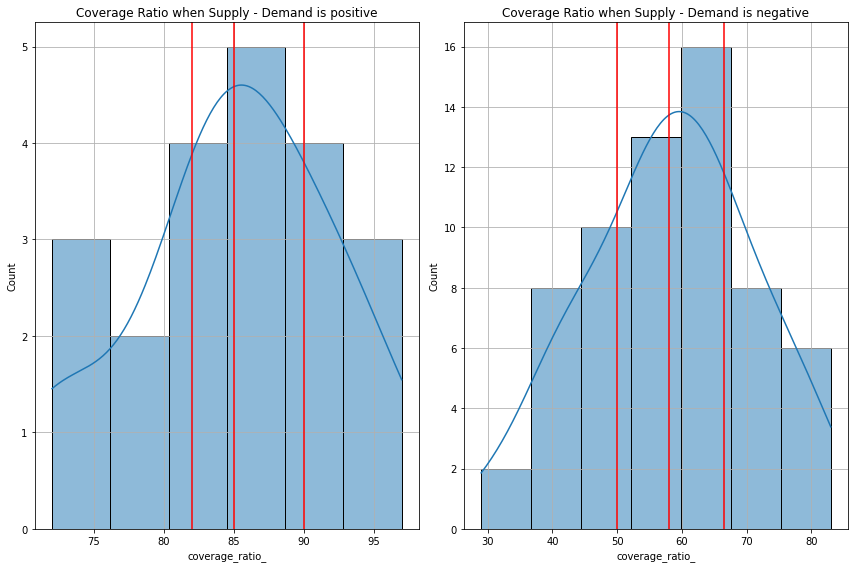

In [165]:
t = undersupplied.reset_index()[['day_name','date_hour']]
t = t.merge(df, on=['day_name','date_hour'])

graf = t[['people_saw_0_cars_unique','people_saw_1_cars_unique','coverage_ratio_','online_h','active_drivers']].copy()
graf['demand'] = t['people_saw_0_cars_unique'] + t['people_saw_1_cars_unique']
graf.drop(columns={'people_saw_0_cars_unique','people_saw_1_cars_unique'},inplace=True)
graf.rename(columns={'active_drivers':'supply'}, inplace=True)
graf['dif'] = graf['supply'] - graf['demand']

fig = plt.figure(figsize = (12,8))

plt.subplot(1,2,1)
sn.histplot(graf[graf['dif'] > 0].coverage_ratio_, kde=True)
plt.axvline(graf[graf['dif'] > 0].coverage_ratio_.quantile(0.75), color='r')
plt.axvline(graf[graf['dif'] > 0].coverage_ratio_.quantile(0.50), color='r')
plt.axvline(graf[graf['dif'] > 0].coverage_ratio_.quantile(0.25), color='r')
plt.grid()
plt.title('Coverage Ratio when Supply - Demand is positive')

plt.subplot(1,2,2)
sn.histplot(graf[graf['dif'] < 0].coverage_ratio_, kde=True)
plt.axvline(graf[graf['dif'] < 0].coverage_ratio_.quantile(0.75), color='r')
plt.axvline(graf[graf['dif'] < 0].coverage_ratio_.quantile(0.50), color='r')
plt.axvline(graf[graf['dif'] < 0].coverage_ratio_.quantile(0.25), color='r')
plt.grid()
plt.title('Coverage Ratio when Supply - Demand is negative')

plt.tight_layout()
plt.show()


Since the objective is to ensure that we have a good coverage ratio, we must look at the graph where our demand is negative and consider the next question in which we will have to calculate how much earning we can guarantee so that we can attract more supply. Therefore we will try to push the coverage ratio distribution curve of the negative demand graph closer to the curve in the positive demand graph.

Therefore I'll consider that the optimal value to ensure a good coverage ratio during the peak hours 85% because this is the value of the 0.5 quantile of the positive demand graph.

###Predicting the Optimal Online Hours for Good Coverage Ratio

---

In order to proceed with this analysis we must understand the relationship between our data. This questions is asking for us to give the `online_h` needed for a **coverage ratio**. 

For this I'll be using a Linear Model in order to prodict what is the optimal online_h value for a good coverage ratio. 

A Linear Model needs an independent variable and a dependent variable:

  * Independent Variable = `coverage ratio`
  * Dependent Variable = `online hours`

The way that a Linear Regression works is by defining the optimal line that cross between our data. This line is explained by:

`𝑦 = 𝑎𝑥 + 𝑏`

Where:

  * `y = Dependent variable` and `x= Independent variable`.
  * `𝑎 = slope = the predicted change in the response for every one unit increase in the x-variable`
  * `𝑏 = intercept = the predicted value of the response when the x-variable is zero`

In [166]:
print('The pearson correlation value is: {}'.format(df[['coverage_ratio_','online_h']].corr().values[0][1]))

The pearson correlation value is: 0.608499083990536


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:               online_h   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     492.1
Date:                Mon, 18 Apr 2022   Prob (F-statistic):           3.99e-86
Time:                        16:19:26   Log-Likelihood:                -3015.1
No. Observations:                 839   AIC:                             6034.
Df Residuals:                     837   BIC:                             6044.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -4.6348      1.292     

Text(0.5, 1.0, 'Scatter Plot + Linear Regression')

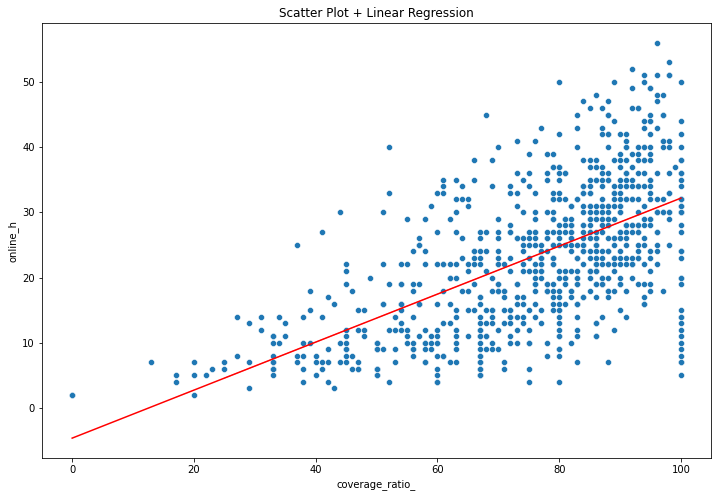

In [167]:
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

#Removing the null line and the outlier cause it will interfere with the model fit
q2 = df[df.coverage_ratio_>=0]

y = q2['online_h'] # dependent variable
x = q2['coverage_ratio_'] # independent variable

x = sm.add_constant(x) # adding a constant
lm = sm.OLS(y,x).fit() # fitting the model
lm.predict(x)

print(lm.summary())

y_pred = lm.params.values[1] * x['coverage_ratio_'] + lm.params.values[0]

print('---- \n')
print(f'The Linear Model Formula is: {lm.params.values[1]}' + f'x + {lm.params.values[0]}')
print('\n')
print(f'RMSE: {np.sqrt(mean_squared_error(y,y_pred))}')

# Plotting Graph
fig = plt.figure(figsize = (12,8))
sn.scatterplot(x=x['coverage_ratio_'], y=y)
sn.lineplot(x=x['coverage_ratio_'],y=y_pred, color='red')
plt.title('Scatter Plot + Linear Regression')

**Main Evaluation Variables:**

  * `Pearson Correlation = ~60%`. The Pearson correlation indicates that if the variable has a linear correlation. The result is moderate and it's a good indicator that we may not have a strong R² in our tests.

  * `R² = 0.370.` The R² evaluates is the amount of variability in the response variable that can be explained by the x-variable in our model. Due to it's value we may consider that coverage_ratio explains 37% of the variability in online_h.

  * `RMSE = 8.799.` MSE stands for Mean Squared Error. It is the average of the square of the errors, being error the difference between observed values and predicted ones. The R means root, and it turns MSE back to the normal scale since it is a squared metric. The bigger the value, the greater the error.

  * `p-value = ~0.` As stated before the p-value evaluates the hypothesis testing. Since coverage ratio has a p-value<=5% we can determine that it is statistically significant.


**Disclaimer**

The R² has its failability and may not explain the variability in the response variable, as it is explained on this [article](https://data.library.virginia.edu/is-r-squared-useless/), therefore I'll proceed using this model due to the results we got from p-value and RMSE.

####Conclusions

---

In order to answer this questions I had to identify what is a good coverage ratio and how to predict the online (h) needed to ensure it.

> For the coverage ratio the optimal coverage ratio chosen is 85% (0.85) since it is the 0.5 quantile of the coverage ratio when our demand is bigger than the supply during peak hours.

> For the prediction part, I identified tha the formula of the line is: 0.36x + -4.63.

Therefore the number of hours needed to ensure a good quality ratio is: 

In [ ]:
print(f'The number of hours needed to ensure a good quality of 85% during undersupplied hours is: {lm.params.values[1]*85 + lm.params.values[0]}')
print(f'The number of hours needed to ensure a good quality of 100% during undersupplied hours is: {lm.params.values[1]*100 + lm.params.values[0]}')

The number of hours needed to ensure a good quality of 85% during undersupplied hours is: 26.65317469703808
The number of hours needed to ensure a good quality of 100% during undersupplied hours is: 32.174579108298346


#Question 3

---

During peak hours, we can guarantee the drivers a certain amount of income. If the drivers make less than the guaranteed amount, we will pay them the difference. Please calculate how much earning we can guarantee so that we can attract more supply. Please explain your reasonings and you can assume the following:

  > Finished Rides have an average value of €10 (80% goes to drivers, 20% is our revenue)

  > With extra online hours available we will be able to capture the "missed coverage", i.e. "People saw 0 cars" in the demand sample data


In [112]:
#Dataset of only peak hours
t = undersupplied.reset_index()[['day_name','date_hour']]
q3 = t.merge(df, on=['day_name','date_hour'])

#Calculating the increment for the coverage_ratio_ to reach it's optimal value of 0.85 (85) and 1 (100)
q3 = q3[['date_hour','day_name', 'active_drivers', 'finished_rides','people_saw_0_cars_unique','people_saw_1_cars_unique','coverage_ratio_','online_h','rides_per_online_hour']]
q3['demand'] = q3['people_saw_0_cars_unique']+q3['people_saw_1_cars_unique']
q3['increment_85'] = q3['demand']*0.85 - q3['people_saw_1_cars_unique']
q3['increment_100'] = q3['demand']*1 - q3['people_saw_1_cars_unique']

#Calculating the adjusted online_h for our incremented coverage_ratio of 0.85 (85) and 1.0 (100)
q3['online_h_85'] = 0.3680936274173511*(q3['demand']*0.85) + -4.6347836334367605
q3['online_h_100'] = 0.3680936274173511*q3['demand'] + -4.6347836334367605

After we have calculated the increment value using the linear model formula of the correlation of coverage_ratio and online_h, I  be calculating the new number of finished rides based on the values of finished rides per hour

Text(0.5, 1.0, 'Earnings at coverage ratio of 85% and 100%')

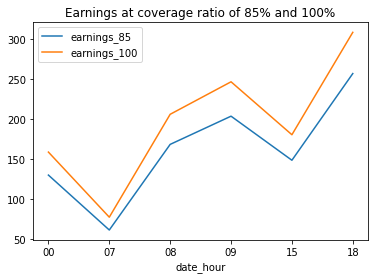

In [115]:
#Calculating the adjusted online_h for our incremented coverage_ratio of 0.85 (85) and 1.0 (100)
q3['finished_rides_85'] = q3['rides_per_online_hour'] * q3['online_h_85']
q3['finished_rides_100'] = q3['rides_per_online_hour'] * q3['online_h_100']

#Calculating the earnings
q3['earnings_85'] = q3.finished_rides_85 * 8
q3['earnings_100'] = q3.finished_rides_100 * 8

#Plotting the medians
q3.groupby('date_hour').median()[['earnings_85','earnings_100']].plot()
plt.title('Earnings at coverage ratio of 85% and 100%')

In [114]:
print('Table of values we must guarantee on our peak hour per day \n')
q3.groupby(['day_name','date_hour']).median()[['earnings_85','earnings_100']]

Table of values we must guarantee on our peak hour per day 



earnings_85  earnings_100
day_name  date_hour                           
Friday    00          130.368871    159.133179
          08          211.895129    257.532850
          09          308.448266    370.928478
          15          148.932057    180.841358
          18          188.932250    227.573246
Monday    07           61.668520     77.720347
          08          181.422161    221.878596
          09          192.534304    234.231950
Thursday  08          168.764801    206.398694
          09          190.032933    230.962000
          18          280.807388    336.904856
Tuesday   08          134.551949    164.447041
          09          218.968363    263.956767
          18          233.894467    280.927999
Wednesday 08          136.016388    165.646453
          09          204.046932    247.056464
          18          292.458860    351.135929

In [117]:
q3[['earnings_85','earnings_100']].median()

earnings_85     178.182884
earnings_100    216.170147
dtype: float64

####Conclusions

----

The value that we must guarantee our drivers to make at a 85% (good coverage rate) is 178.18 euros, and at a 100% coverage rate is 216.17 euros on average during peak hours.

In order to come to this conclusion I have developed the following reasoning: 

> 1. Calculate the demand number of 85% and 100% coverage ratio
> 2. Calculate the online_h needed for the demand of 85% and 100% coverage ratio using the linear model formula
> 3. Calculate the number of finished rides using the finished_rides_per_hour already calculate. Why? Because I understand that as a performance metric of the driver, and therefore I chose to keep it the same and use it to calculate how many finished_rides I'll have with the predicted online_h
> 4. Calculate the earnings the driver will have on those rides (80% goes to driver and the average is 10 euros, then 8 euros goes to driver)
> 5. Calculate the earnings medians per hour and day